# CLUSTERING

In v2 the voltage categories are reduced so the total number of clusters including all dimensions (overvoltages, undervoltages and overloadings) are small in number (close to 10).
Also for each cluster three points are selected: the two extremes(min and max) and the middle point. This choice is based by projecting all the points on a line using a weight function eg:
f1/3 + f2/3 + f3/3, where f1,f2,f3 can be the values of overvoltage, undervoltage and overloading on that day.

Two representative buses are choses as a reference for the overvoltage and undervoltages respectively. Finally the overloading value is based on the ilo index which accounts for the total overloading of all lines in one day.
However I will probably change the first part so that instead of depending only on the chosen representative buses, instead all the buses of the network will be taken into account to categorize the voltage violations on each day. That can be done by just calculating the min and max of all buses in the network for a day.

In [1]:
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
import json

import tempfile
import matplotlib.pyplot as plt

In [2]:
CURRENT_SCENARIO = 'initial'
YEAR = 15
nominal_voltage = 416 # V

working_folder = os.getcwd()
root_dir = os.path.abspath(os.path.join(working_folder, os.pardir))
data_path = os.path.join(root_dir, 'data', CURRENT_SCENARIO)
network_path = os.path.join(data_path,'network')
output_dir  = os.path.join(data_path, "time_series_calculation")

In [3]:
#Load pandapower results of magnitude of voltages and lines loading
pp_vm = os.path.join(output_dir,'res_bus','vm_pu.json')
df_pp_vm = pd.read_json(pp_vm)*(416)
pp_ld = os.path.join(output_dir,'res_line','loading_percent.json')
df_pp_ld = pd.read_json(pp_ld)

# This is required since json makes keys as string type, the index order is like 1, 10, 100 ,...
df_pp_vm.index = df_pp_vm.index.astype(np.int64)
df_pp_vm = df_pp_vm.sort_index()
df_pp_ld.index = df_pp_ld.index.astype(np.int64)
df_pp_ld = df_pp_ld.sort_index()

# Convert the DataFrame to a numpy array
bus_voltage_data_array = df_pp_vm.values
line_loading_data_array = df_pp_ld.values

In [6]:
np.mean(bus_voltage_data_array[:,92])

416.0341796740561

In [4]:
# Calculate voltage descriptive statistics

max_dv_ov_per_bus = [] # the maximum overvoltage deviation that appears in each bus throughout the year
max_dv_uv_per_bus = [] # the maximum undervoltage deviation that appears in each bus throughout the year

max_ov_all_buses = [] # list of the maximum overvoltages that appears in each bus daily
max_uv_all_buses = [] # list of the maximum undervoltages that appears in each bus daily

var_v_all_buses = [] # list of the voltage variance in each bus daily

for bus_index in range(117):
    # Extract voltage data for the current bus
    bus_voltages = bus_voltage_data_array[:, bus_index].reshape((-1, 96))

    # Calculate maximum positive overvoltage for each day
    voltage_deviations = bus_voltages - nominal_voltage

    # ov - daily
    max_overvoltages = np.maximum(0, np.max(voltage_deviations, axis=1))
    max_ov_all_buses.append(max_overvoltages)
    # append max yearly overvoltages for each bus
    max_dv_ov_per_bus.append(np.max(max_overvoltages))

    # uv
    max_undervoltages = np.maximum(0, - np.min(voltage_deviations, axis=1))
    max_uv_all_buses.append(max_undervoltages)
    # append max yearly undervoltages for each bus
    max_dv_uv_per_bus.append(np.max(max_undervoltages))

    # voltage sigma^2 - daily - for each bus
    var_v_per_day = np.var(bus_voltages, axis=1)
    var_v_all_buses.append(var_v_per_day)

# Convert the lists to NumPy arrays
max_ov_all_buses = np.array(max_ov_all_buses)   # (117,365)
max_uv_all_buses = np.array(max_uv_all_buses)   # (117,365)
max_dv_ov_per_bus = np.array(max_dv_ov_per_bus) # (117,)
max_dv_uv_per_bus = np.array(max_dv_uv_per_bus) # (117,)
var_v_all_buses = np.array(var_v_all_buses)     # (117,365)

In [5]:
# function to find CRITICAL BUSES for overvoltages or undervoltages
    # KEEP ONLY BUSES ABOVE Q3 (75% quartile) of voltage deviation
def find_critical_buses(max_dv_per_bus):

    # Calculate the 75th percentile (Q3)
    q3 = np.percentile(max_dv_per_bus, 75)

    # Find indices of elements above Q3
    buses_above_q3 = {i: value for i, value in enumerate(max_dv_per_bus) if value > q3}

    # Find median of values above q3
    # q4_median = np.median(list(buses_above_q3.values()))

    return buses_above_q3

In [6]:
# Find critical buses for ov and uv
buses_q4_ov = find_critical_buses(max_dv_ov_per_bus)
buses_q4_uv = find_critical_buses(max_dv_uv_per_bus)

# Merge critical buses
# Step 1: Extract buses
keys_dict1 = set(buses_q4_ov.keys())
keys_dict2 = set(buses_q4_uv.keys())

# Step 2: Combine keys
critical_buses = keys_dict1.union(keys_dict2)
critical_buses = sorted(critical_buses)

In [7]:
def find_median_cb(buses_q4):
    values = list(buses_q4.values())
    median_value = np.median(values)

    # Find the key corresponding to the median value
    key_with_median = next(key for key, value in buses_q4.items() if value == median_value)

    return key_with_median

ref_bus_ov = find_median_cb(buses_q4_ov)
ref_bus_uv = find_median_cb(buses_q4_uv)

In [8]:
print(f"The two reference buses are: Bus {ref_bus_ov}, for ov and the common days")
print(f"and: Bus {ref_bus_uv}, for uv cases")

The two reference buses are: Bus 92, for ov and the common days
and: Bus 56, for uv cases


In [9]:
# Calculate loading descriptive statistics

max_ld_all_lines = [] # list of the maximum overloading that appears in each line daily
max_ld_per_line_yearly = [] # the maximum overloading that appears in each line throughout the year

ilo_each_line_daily = [] # list of the integrated line overloading for each bus daily

def calculate_ilo(loading_values, threshold=100):
    overloadings = np.maximum(0, loading_values - threshold)
    ilo = np.sum(overloadings, axis=1)
    return ilo 

for line_index in range(line_loading_data_array.shape[1]):
    # Extract voltage data for the current bus
    line_loadings = line_loading_data_array[:, line_index].reshape((-1, 96))

    # overloading - daily
    max_daily_loadings = np.max(line_loadings, axis=1)
    max_ld_all_lines.append(max_daily_loadings)
    # append max yearly overvoltages for each bus
    max_ld_per_line_yearly.append(np.max(max_daily_loadings))

    # integrated overloading - daily - for each bus
    line_daily_ilo = calculate_ilo(line_loadings)
    ilo_each_line_daily.append(line_daily_ilo)

# Convert the lists to NumPy arrays
max_ld_all_lines = np.array(max_ld_all_lines)               # (115,365)
max_ld_per_line_yearly = np.array(max_ld_per_line_yearly)   # (115,)
ilo_each_line_daily = np.array(ilo_each_line_daily)         # (115,365)
ilo_all_lines_daily = np.sum(ilo_each_line_daily, axis=0)   # (365,)

In [10]:
# Find days that are overloaded

days_with_overloading_ind = np.where(ilo_all_lines_daily > 0)[0]
days_with_overloading = days_with_overloading_ind + 1

In [11]:
# Define Voltage Deviation Limits

soft_volt_limit  = 0.05 * nominal_voltage
upper_volt_limit  = 0.10 * nominal_voltage

In [12]:
day_categories = {
    "normal": [],
    "limited-ov/uv": [],
    "ov": [],
    "ov + ol": [],
    "uv": [],
    "uv + ol": [],
    "ov + uv": [],
    "ov + uv + ol": [],
    "rest": []
}

For Max OV Keep Days **{244, 111}** and   
for max UV keep days **{351}**.  
Those days are calculated in clustering_v2.ipynb  

In [13]:
# CATEGORIZE DAYS FOR CRITICAL BUSES - BASED ON THE VOLTAGES

ovs = max_ov_all_buses[ref_bus_ov, :]  # daily max overvoltages for ov ref bus
uvs = max_uv_all_buses[ref_bus_uv, :]  # daily max undervoltages for uv ref bus

for day in range(len(ovs)):

    # Assign each day to the respective category
    if  0 < ovs[day] < soft_volt_limit  and 0 < uvs[day] < soft_volt_limit and day not in days_with_overloading_ind:
        day_categories["normal"].append(day + 1)
    elif ((soft_volt_limit  <= ovs[day] < upper_volt_limit and 0                <= uvs[day] < upper_volt_limit and day not in days_with_overloading_ind) or 
          (0                <= ovs[day] < soft_volt_limit  and soft_volt_limit  <= uvs[day] < upper_volt_limit and day not in days_with_overloading_ind)):
        day_categories["limited-ov/uv"].append(day + 1)
    elif (upper_volt_limit  <= ovs[day]                    and 0                <= uvs[day] < upper_volt_limit and day in days_with_overloading_ind):
        day_categories["ov + ol"].append(day + 1)
    elif (upper_volt_limit  <= ovs[day]                    and 0                <= uvs[day] < upper_volt_limit and day not in days_with_overloading_ind):
        day_categories["ov"].append(day + 1)
    elif (0                 <= ovs[day] < upper_volt_limit and upper_volt_limit <= uvs[day]                    and day in days_with_overloading_ind):
        day_categories["uv + ol"].append(day + 1)
    elif (0                 <= ovs[day] < upper_volt_limit and upper_volt_limit <= uvs[day]                    and day not in days_with_overloading_ind):
        day_categories["uv"].append(day + 1)
    elif (upper_volt_limit  <= ovs[day]                    and upper_volt_limit <= uvs[day]                    and day in days_with_overloading_ind):
        day_categories["ov + uv + ol"].append(day + 1)
    elif (upper_volt_limit  <= ovs[day]                    and upper_volt_limit <= uvs[day]                    and day not in days_with_overloading_ind):
        day_categories["ov + uv"].append(day + 1)
    else:
        day_categories["rest"].append(day + 1)

In [14]:
# Create a list with the types that each day of the year belongs to
def create_day_category_list(day_dict):
    # Find the maximum day value
    max_day = max(max(days, default=0) for days in day_dict.values())

    # Initialize a list of 'unknown' for all days
    day_categories = ['unknown'] * (max_day + 1)  # +1 because list indexing starts at 0

    # Assign categories to corresponding day indices
    for category, days in day_dict.items():
        for day in days:
            day_categories[day] = category

    return day_categories[1:]  # slice to ignore index 0 since there's no day 0

In [15]:
no_category_days = day_categories["rest"]
len(no_category_days)

0

In [16]:
# Print keys and total number of entries for each key
for key, entries in day_categories.items():
    print(f"Key: {key}, Total Entries: {len(entries)}")

Key: normal, Total Entries: 0
Key: limited-ov/uv, Total Entries: 13
Key: ov, Total Entries: 45
Key: ov + ol, Total Entries: 0
Key: uv, Total Entries: 119
Key: uv + ol, Total Entries: 23
Key: ov + uv, Total Entries: 137
Key: ov + uv + ol, Total Entries: 28
Key: rest, Total Entries: 0


Choose the representative days. 
This part is different from the v1 as instead from choosing the days based on variance, a normalization function is used with equivalent weight factor for all three dimensions (ov, uv and ol)

In [19]:
# Function to normalize an array
def normalize_array(array):
    """
    Normalize an array based on the formula:
    (value - min) / (max - min)
    """
    min_val = np.min(array)
    max_val = np.max(array)
    # Prevent division by zero if max and min are the same
    if max_val - min_val == 0:
        return array
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

# Function to calculate a weighted average of normalized values
def calculate_weighted_average(ovs, uvs, ilo):
    """
    Calculate a weighted average of normalized values from three arrays.
    The weights are equally distributed.
    """
    n_ovs = normalize_array(ovs)
    n_uvs = normalize_array(uvs)
    n_ilo = normalize_array(ilo)
    return (n_ovs + n_uvs + n_ilo) / 3

combined_values = calculate_weighted_average(ovs, uvs, ilo_all_lines_daily)

In [23]:
# Choose the representative days for each cluster
results = {}
for category, days in day_categories.items():
    # Skip certain categories
    if category in ['normal', 'limited-ov/uv']:
        continue

    if not days:
        results[category] = []  # Assign empty list for empty categories
        continue

    # Calculate and sort normalized values for each day
    normalized_values = [combined_values[day - 1] for day in days]
    days_sorted_by_value = sorted(zip(normalized_values, days), key=lambda x: x[0])

    # Determine representative days based on the number of days
    if len(days) <= 60:
        # Pick indices that divide the list into roughly equal parts (min, median, max)
        indices = [0, len(days_sorted_by_value) // 2, -1]
    elif len(days) <= 90:
        # Pick indices for min, 1/3, 2/3, max
        indices = [0, len(days_sorted_by_value) // 3, 2 * len(days_sorted_by_value) * 3, -1]
    else:
        # For more than 90 days, pick min, 25%, 50%, 75%, max        
        indices = [0, len(days_sorted_by_value) // 4, len(days_sorted_by_value) // 2, 3 * len(days_sorted_by_value) // 4, -1]

    # Extract the days corresponding to the selected indices
    results[category] = [days_sorted_by_value[i][1] for i in indices]

# Display the results
print(results)

{'ov': [150, 206, 100], 'ov + ol': [], 'uv': [316, 332, 34, 310, 35], 'uv + ol': [217, 14, 351], 'ov + uv': [72, 218, 265, 116, 82], 'ov + uv + ol': [106, 343, 313], 'rest': []}


In [24]:
# Create clusters DataFrame

year_id = [year] * len(combined_values)
days_id = list(range(1, len(combined_values) + 1))
day_cluster_types = create_day_category_list(day_categories)
df = pd.DataFrame(list(zip(year_id, days_id, day_cluster_types, combined_values)),
               columns =['year', 'id', 'type', 'f_value'])
# save file
df.to_csv(os.path.join(data_path, 'clusters.csv'), index=False)  # Set index=False to not save row indices

In [32]:
results

{'ov': [150, 206, 100],
 'ov + ol': [],
 'uv': [316, 332, 34, 310, 35],
 'uv + ol': [217, 14, 351],
 'ov + uv': [72, 218, 265, 116, 82],
 'ov + uv + ol': [106, 343, 313],
 'rest': []}

In [30]:
# Save representative days data to json file:
output_file = os.path.join(data_path, 'clusters_representative.json')

with open(output_file, 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(results, f, indent=4)

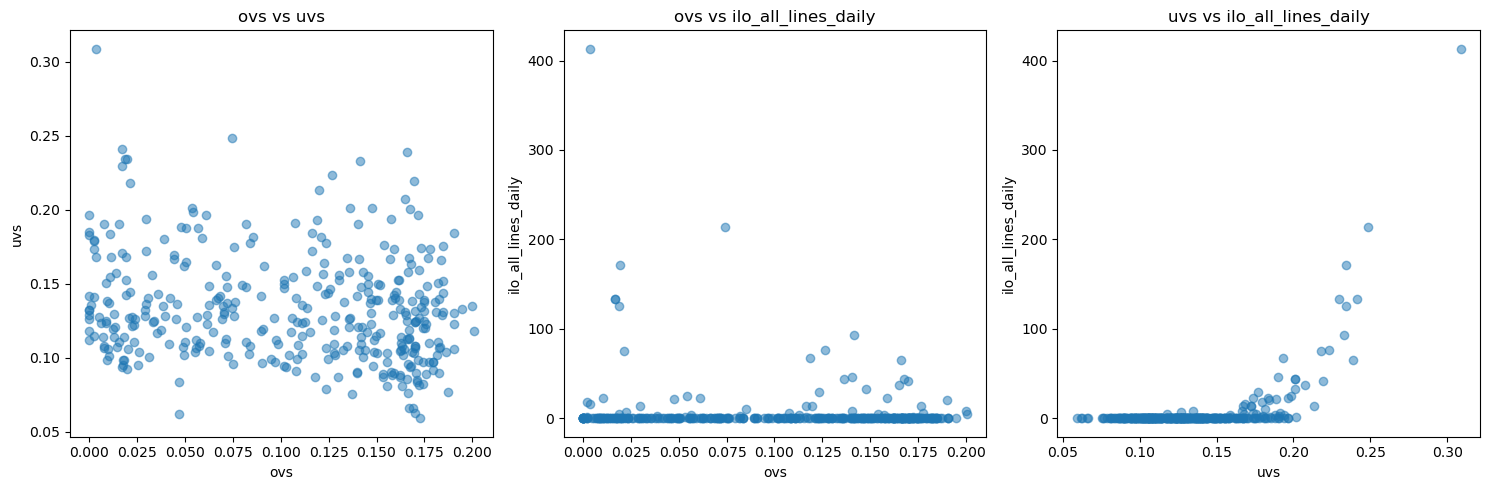

In [44]:
# Create scatter plots
plt.figure(figsize=(15, 5))

# Scatter plot for ovs vs uvs
plt.subplot(1, 3, 1)
plt.scatter(ovs/416, uvs/416, alpha=0.5)
plt.title('ovs vs uvs')
plt.xlabel('ovs')
plt.ylabel('uvs')

# Scatter plot for ovs vs ilo_all_lines_daily
plt.subplot(1, 3, 2)
plt.scatter(ovs/416, ilo_all_lines_daily, alpha=0.5)
plt.title('ovs vs ilo_all_lines_daily')
plt.xlabel('ovs')
plt.ylabel('ilo_all_lines_daily')

# Scatter plot for uvs vs ilo_all_lines_daily
plt.subplot(1, 3, 3)
plt.scatter(uvs/416, ilo_all_lines_daily, alpha=0.5)
plt.title('uvs vs ilo_all_lines_daily')
plt.xlabel('uvs')
plt.ylabel('ilo_all_lines_daily')

plt.tight_layout()
plt.show()

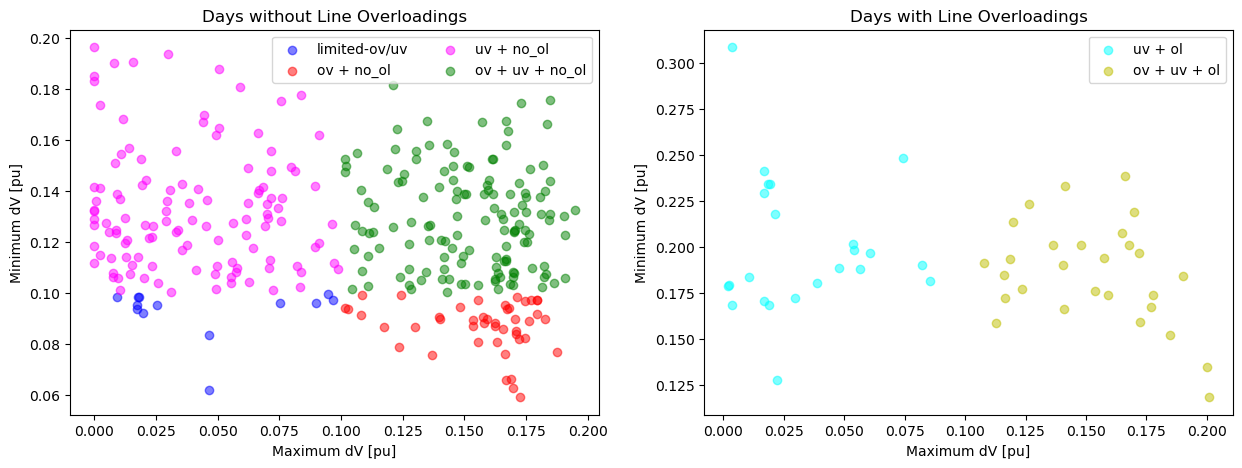

In [45]:

# Define the color mapping for each category
category_colors = {
    "normal": "grey",
    "limited-ov/uv": "blue",
    "ov + ol": "b",
    "ov": "red",
    "uv + ol": "cyan",
    "uv": "magenta",
    "ov + uv + ol": "y",
    "ov + uv": "g",
    "rest": "orange"
}

# Get the index of days with overloading
days_with_overloading_ind = np.where(ilo_all_lines_daily > 0)[0]
days_with_overloading = set(days_with_overloading_ind + 1)

# Create two scatter plots side by side
plt.figure(figsize=(15, 5))

# Plot for days without overloading
plt.subplot(1, 2, 1)
plt.title('Days without Line Overloadings')
plt.xlabel('Maximum dV [pu]')
plt.ylabel('Minimum dV [pu]')
for category, days in day_categories.items():
    # Filter days without overloading
    days_no_overload = [day-1 for day in days if day not in days_with_overloading]
    if days_no_overload:
        plt.scatter(ovs[days_no_overload]/416, uvs[days_no_overload]/416, alpha=0.5, label=category, color=category_colors[category])
plt.legend(loc='upper right', ncol=2)

# Plot for days with overloading
plt.subplot(1, 2, 2)
plt.title('Days with Line Overloadings')
plt.xlabel('Maximum dV [pu]')
plt.ylabel('Minimum dV [pu]')
for category, days in day_categories.items():
    # Filter days with overloading
    days_with_overload = [day-1 for day in days if day in days_with_overloading]
    if days_with_overload:
        plt.scatter(ovs[days_with_overload]/416, uvs[days_with_overload]/416, alpha=0.5, label=category, color=category_colors[category])
plt.legend(loc='upper right')

plt.show()

Now plot the diagrams including the three points selected from each cluster.

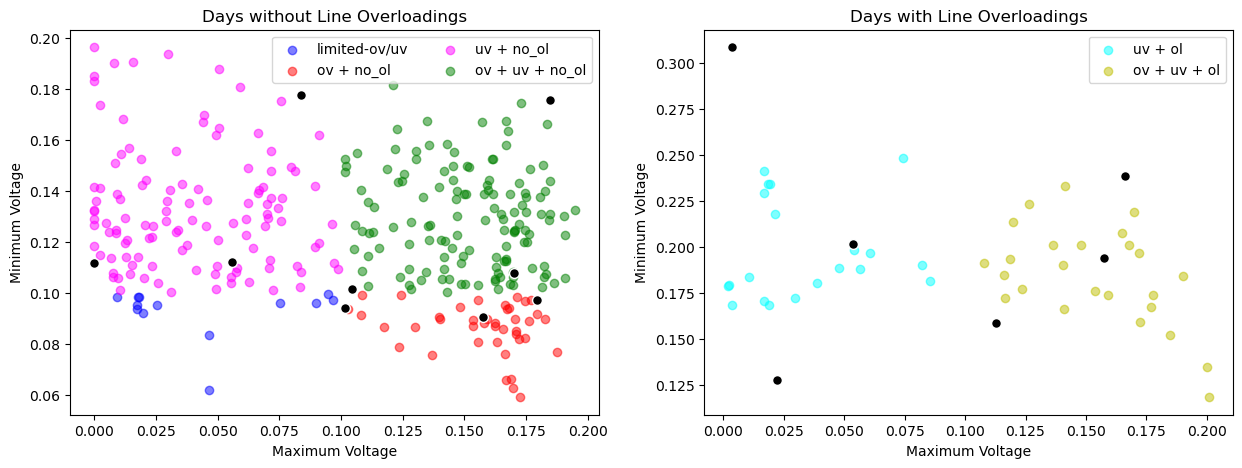

In [46]:
# Define the color mapping for each category
category_colors = {
    "normal": "grey",
    "limited-ov/uv": "blue",
    "ov + ol": "b",
    "ov": "red",
    "uv + ol": "cyan",
    "uv": "magenta",
    "ov + uv + ol": "y",
    "ov + uv": "g",
    "rest": "orange"
}

# Get the index of days with overloading
days_with_overloading_ind = np.where(ilo_all_lines_daily > 0)[0]
days_with_overloading = set(days_with_overloading_ind + 1)

# Create two scatter plots side by side
plt.figure(figsize=(15, 5))

# Plot for days without overloading
plt.subplot(1, 2, 1)
plt.title('Days without Line Overloadings')
plt.xlabel('Maximum Voltage')
plt.ylabel('Minimum Voltage')
for category, days in day_categories.items():
    # Filter days without overloading
    days_no_overload = [day-1 for day in days if day not in days_with_overloading]
    if days_no_overload:
        plt.scatter(ovs[days_no_overload]/416, uvs[days_no_overload]/416, alpha=0.5, label=category, color=category_colors[category])

# Plot special points from results dictionary in black for days without overloading
for category, special_days in results.items():
    special_days_no_overload = [day-1 for day in special_days if day not in days_with_overloading]
    if special_days_no_overload:
        plt.scatter(ovs[special_days_no_overload]/416, uvs[special_days_no_overload]/416, color='black', edgecolor='white', s=50)

plt.legend(loc='upper right', ncol=2)

# Plot for days with overloading
plt.subplot(1, 2, 2)
plt.title('Days with Line Overloadings')
plt.xlabel('Maximum Voltage')
plt.ylabel('Minimum Voltage')
for category, days in day_categories.items():
    # Filter days with overloading
    days_with_overload = [day-1 for day in days if day in days_with_overloading]
    if days_with_overload:
        plt.scatter(ovs[days_with_overload]/416, uvs[days_with_overload]/416, alpha=0.5, label=category, color=category_colors[category])

# Plot special points from results dictionary in black for days with overloading
for category, special_days in results.items():
    special_days_with_overload = [day-1 for day in special_days if day in days_with_overloading]
    if special_days_with_overload:
        plt.scatter(ovs[special_days_with_overload]/416, uvs[special_days_with_overload]/416, color='black', edgecolor='white', s=50)

plt.legend(loc='upper right')

plt.show()